# Training a GAP model

## steps
    1. generate a small dataset of water structures 
        - use CP2K if you havea access to it
        - otherwise: use any simple potential implemented in ASE, just for trying this out I have used EMT here
    1. generate e0 values
    1. separate a training and a validation dataset
    1. **train the model**
    1. look at the outcome of the model
    
## here we will fit twice, to see the difference between a 2b-only and a 2b+3b fit

In [2]:
# general imports 
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp

# ase imports
import ase.io
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
# for MD
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

In [12]:
# helper functions
def make_water(density, super_cell=[3, 3, 3]):
    """ Geenrates a supercell of water molecules with a desired density.
        Density in g/cm^3!!!"""
    h2o = molecule('H2O')
    a = np.cbrt((sum(h2o.get_masses()) * units.m ** 3 * 1E-6 ) / (density * units.mol))
    h2o.set_cell((a, a, a))
    h2o.set_pbc((True, True, True))
    #return cp(h2o.repeat(super_cell))
    return h2o.repeat(super_cell)

def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

## generating data only with ASE, using the EMT calculator

This is only for the demonstration of how to do it, this run is will be done very fast. There is no practical use of the data beyond lerning the use teach_sparse, quip, etc. with it.

In [13]:
# Running MD with ASE's EMT

from ase.calculators.emt import EMT
calc = EMT()

T = 150  # Kelvin

# Set up a grid of water
water = make_water(1.0, [3, 3, 3])
water.set_calculator(calc)

# We want to run MD using the Langevin algorithm
# with a time step of 1 fs, the temperature T and the friction
# coefficient to 0.002 atomic units.
dyn = Langevin(water, 1 * units.fs, T * units.kB, 0.0002)

def printenergy(a=water):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

dyn.attach(printenergy, interval=5)

# We also want to save the positions of all atoms after every 5th time step.
traj = Trajectory('dyn_emt.traj', 'w', water)
dyn.attach(traj.write, interval=5)

# Now run the dynamics
printenergy(water)
dyn.run(600)   # CHANGE THIS IF YOU WANT LONGER/SHORTER RUN

/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.820eV  Ekin = 0.053eV (T=413K)  Etot = 0.874eV
Energy per atom: Epot = 0.659eV  Ekin = 0.208eV (T=1611K)  Etot = 0.868eV
Energy per atom: Epot = 0.632eV  Ekin = 0.224eV (T=1736K)  Etot = 0.857eV
Energy per atom: Epot = 0.869eV  Ekin = 0.005eV (T= 39K)  Etot = 0.874eV
Energy per atom: Epot = 0.781eV  Ekin = 0.088eV (T=683K)  Etot = 0.869eV
Energy per atom: Epot = 0.756eV  Ekin = 0.117eV (T=904K)  Etot = 0.873eV
Energy per atom: Epot = 0.706eV  Ekin = 0.164eV (T=1269K)  Etot = 0.870eV
Energy per atom: Epot = 0.703eV  Ekin = 0.158eV (T=1224K)  Etot = 0.861eV
Energy per atom: Epot = 0.867eV  Ekin = 0.006eV (T= 49K)  Etot = 0.873eV
Energy per atom: Epot = 0.701eV  Ekin = 0.163eV (T=1263K)  Etot = 0.864eV
Energy per atom: Epot = 0.679eV  Ekin = 0.189eV (T=1461K)  Etot = 0.868eV
Energy per atom: Epot = 0.823eV  Ekin = 0.049

True

In [17]:
# wrap and save traj in .xyz --- the .traj is a non human readable database file, xyz is much better
out_traj = ase.io.read('dyn_emt.traj', ':')
for at in out_traj:
    at.wrap()
    if 'momenta' in at.arrays: del at.arrays['momenta']
ase.io.write('dyn_emt.xyz', out_traj, 'xyz')

## get e0 for H and O - energies of the isolated atoms

This is the energy of the isolated atom, will be in the teach_sparse string in the following format: `e0={H:energy:O:energy}`

In [18]:
isolated_H = Atoms('H', calculator=EMT(), cell=[20, 20, 20], pbc=True)
isolated_O = Atoms('O', calculator=EMT(), cell=[20, 20, 20], pbc=True)

print('e0_H:',isolated_H.get_potential_energy())
print('e0_O:',isolated_O.get_potential_energy())

# this made the e0 string be the following: e0={H:3.21:O:4.6}

e0_H: 3.21
e0_O: 4.6


## separate the dataset into a training and a validation set

As we have 120 frames from the 600fs MD, I will do it 60,60 with taking even and odd frames for the two

In [19]:
ase.io.write('train.xyz', out_traj[0::2] )  
ase.io.write('validate.xyz', out_traj[1::2])

In [20]:
out_traj[0].arrays.keys()


dict_keys(['numbers', 'positions'])

In [21]:
X_obj = ase.io.read('train.xyz', ':')
energies = [at.get_potential_energy() for at in X_obj]
bonds = [at.get_all_distances() for at in X_obj]

print('bonds:',np.asarray(bonds).shape)
#print('angles:',np.asarray(angles).shape)

bonds: (61, 81, 81)


In [22]:
from ase.visualize import view
from ase.io import write
#write('atoms_start.png', X_obj[0])
#write('atoms_end.png', X_obj[-1])
view(X_obj, viewer='ngl')

## implement our own GP for energy training

Here we will begin defining our training to turn the original data into a training process that can predict energy and force like the GAP program.

/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

Optimal hyperparameters:  [341.2414881313476, 62.011493281717016, 0.785387287336761]


/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'Energy (eV)')

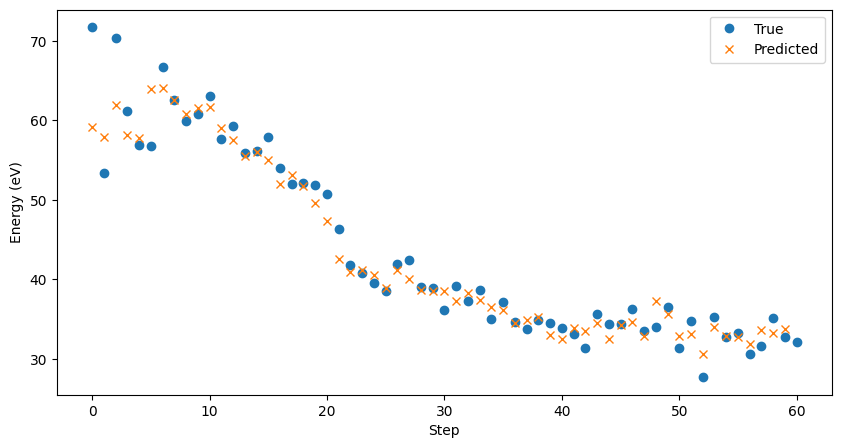

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from skopt.space import Real
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize

X_obj = ase.io.read('train.xyz', ':')
validate_data = ase.io.read('validate.xyz', ':')
X_train = [at.get_positions().flatten() for at in ase.io.read('train.xyz', ':')]
y_energy_train = [at.get_potential_energy() for at in X_obj]
y_force_train = [at.get_forces().flatten() for at in X_obj]

# Extract the features for validation
X_validate = [at.get_positions().flatten() for at in validate_data]
y_energy_val = [at.get_potential_energy() for at in validate_data]

def objective_function(params):
    constant_value, rbf_length_scale, noise_level = params

    # Define the kernel with the current hyperparameters
    kernel_energy = ConstantKernel(constant_value, (1e-3, 1e3)) * RBF(rbf_length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level=noise_level)
    
    # Initialize and train the Gaussian Process model
    gp_energy = GaussianProcessRegressor(kernel=kernel_energy)
    gp_energy.fit(X_train, y_energy_train)

    # Predict on a validation set and calculate MSE
    y_pred = gp_energy.predict(X_validate)
    mse = mean_squared_error(y_energy_val, y_pred)
    return mse


space = [
    Real(1e-3, 1e3, name='constant_value'),
    Real(1e-2, 1e2, name='rbf_length_scale'),
    Real(1e-10, 1, name='noise_level')
]

result = gp_minimize(
    objective_function,               # the function to minimize
    space,                            # the bounds on each dimension of x
    acq_func="EI",                    # the acquisition fsunction
    n_calls=50,                       # the number of evaluations of f
    n_random_starts=10,               # the number of random initialization points
    random_state=123                  # the random seed
)

# Optimal hyperparameters
print("Optimal hyperparameters: ", result.x)

kernel_energy = ConstantKernel(result.x[0], (1e-3, 1e3)) * RBF(result.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result.x[2])

gp_energy = GaussianProcessRegressor(kernel=kernel_energy)
gp_energy.fit(X_train, y_energy_train)

y_energy_pred = gp_energy.predict(X_validate)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_energy_train)), y_energy_train, 'o')
plt.plot(range(len(y_energy_pred)), y_energy_pred, 'x')
legend = ['True', 'Predicted']
plt.legend(legend)
plt.xlabel('Step')
plt.ylabel('Energy (eV)')



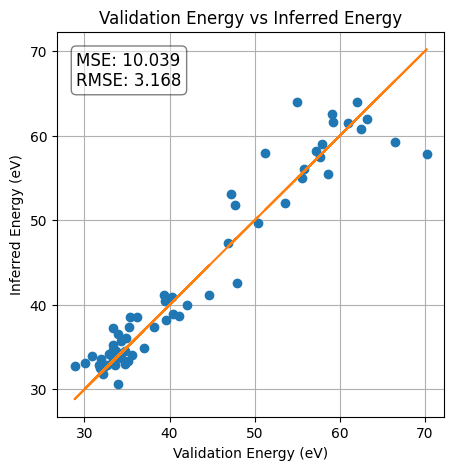

In [42]:
from sklearn.metrics import mean_squared_error

# Calculate MSE and RMSE
mse = mean_squared_error(y_energy_val, y_energy_pred)
rmse = mse ** 0.5

# Plotting
plt.figure(figsize=(5, 5))
plt.plot(y_energy_val, y_energy_pred, 'o')
plt.plot(y_energy_val, y_energy_val, '-')  # Line to plot y = x
plt.xlabel('Validation Energy (eV)')
plt.ylabel('Inferred Energy (eV)')
plt.title('Validation Energy vs Inferred Energy')
plt.grid(True)

# Annotate the plot with MSE and RMSE
plt.text(0.05, 0.95, f'MSE: {mse:.3f}\nRMSE: {rmse:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()


(61, 243)
(61, 1)


/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

[ 1.10495366 -0.07951292 -0.07949631 -0.07946818 -0.07943714 -0.07939941
 -0.07938702 -0.07936056 -0.07929816 -0.07923166 -0.07918224 -0.07912613
 -0.07906865 -0.07898879 -0.07886476 -0.07879931 -0.07896544 -0.07901059
 -0.07884508 -0.07883397 -0.07897769  1.10434024  1.10205607  1.10486106
 -0.07235005 -0.06683453 -0.06331467 -0.06052228 -0.05893639 -0.05612303
 -0.05642643 -0.05368774 -0.0552547  -0.05875453 -0.06593105 -0.06622105
 -0.05888628 -0.05216498 -0.04524493 -0.03925461 -0.03259203 -0.02655404
 -0.02766396 -0.02629326 -0.02326659 -0.01499125 -0.00575762 -0.00489234
 -0.00388141 -0.00410843 -0.00833063 -0.00962021 -0.00261591  0.00819175
  0.01698578  0.02302707  0.0307344   0.03880601  0.04947905  0.06583847]


/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'Energy (eV/A)')

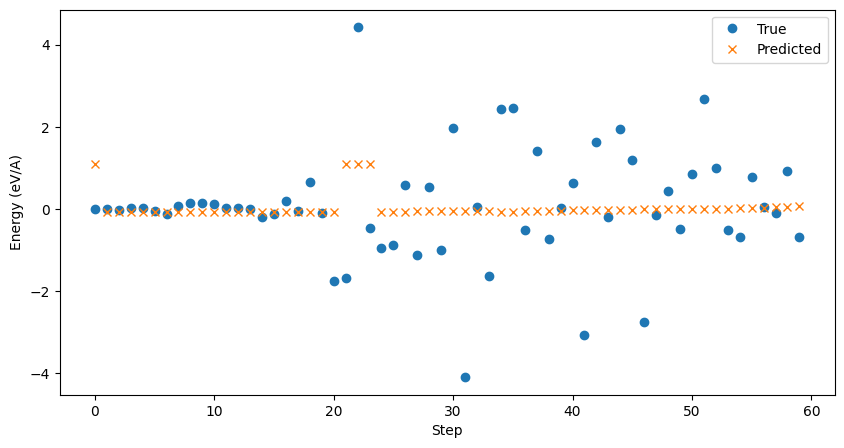

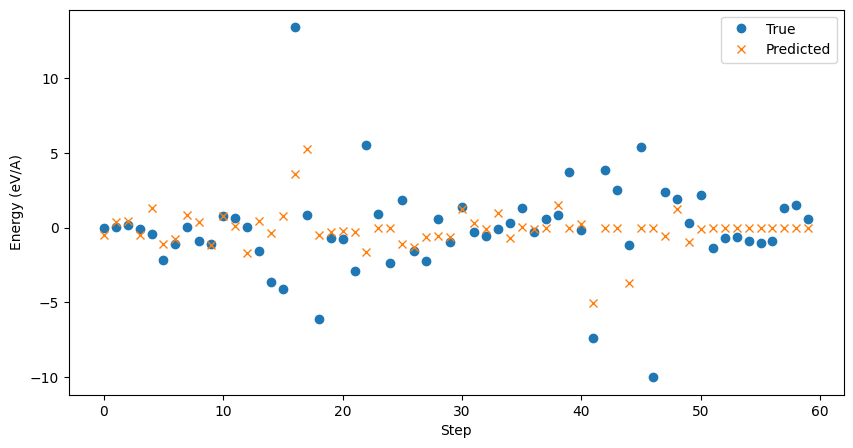

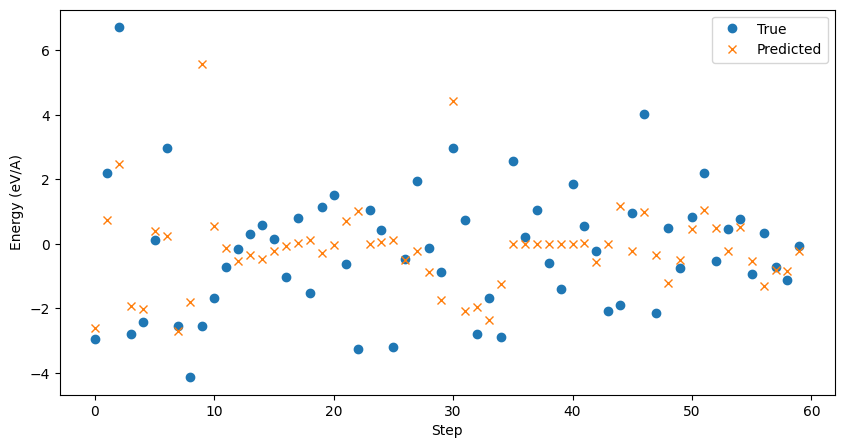

In [25]:
y_force_val = [at.get_forces().flatten() for at in validate_data]

# Define the kernel for force prediction
# kernel_force = ConstantKernel(result.x[0], (1e-3, 1e3)) * RBF(result.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result.x[2])
kernel_force_x = ConstantKernel(10, (1e-3, 1e3)) * RBF(0.5, (1e-2, 1e2)) + WhiteKernel(noise_level=0.01)

gp_force_x = GaussianProcessRegressor(kernel=kernel_force_x)

X_train = np.array(X_train)
y_force_train = np.array(y_force_train)

print(X_train.shape)

X_train_x = X_train[:, 0].reshape(len(X_train), -1)
X_train_y = X_train[:, 1].reshape(len(X_train), -1)
X_train_z = X_train[:, 2].reshape(len(X_train), -1)

print(X_train_x.shape)

y_force_train_x = y_force_train[:, 0].reshape(len(y_force_train), -1)
y_force_train_y = y_force_train[:, 1].reshape(len(y_force_train), -1)
y_force_train_z = y_force_train[:, 2].reshape(len(y_force_train), -1)

X_validate = np.array(X_validate)
y_force_val = np.array(y_force_val)

X_validate_x = X_validate[:, 0].reshape(len(X_validate), -1)
X_validate_y = X_validate[:, 1].reshape(len(X_validate), -1)
X_validate_z = X_validate[:, 2].reshape(len(X_validate), -1)

y_force_val_x = y_force_val[:, 0].reshape(len(y_force_val), -1)
y_force_val_y = y_force_val[:, 1].reshape(len(y_force_val), -1)
y_force_val_z = y_force_val[:, 2].reshape(len(y_force_val), -1)

def objective_function(params, X_train, y_train, X_validate, y_validate):
    constant_value, rbf_length_scale, noise_level = params

    # Define the kernel with the current hyperparameters
    kernel = ConstantKernel(constant_value, (1e-3, 1e3)) * RBF(rbf_length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level=noise_level)
    
    # Initialize and train the Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, y_train)

    # Predict on a validation set and calculate MSE
    y_pred = gp.predict(X_validate)
    mse = mean_squared_error(y_validate, y_pred)
    return mse


space = [
    Real(1e-3, 1e3, name='constant_value'),
    Real(1e-2, 1e2, name='rbf_length_scale'),
    Real(1e-10, 1, name='noise_level')
]

result_x = gp_minimize(
    lambda params: objective_function(params, X_train_x, y_force_train_x, X_validate_x, y_force_val_x),
    space,
    acq_func="EI",
    n_calls=50,
    n_random_starts=10,
    random_state=123
)

kernel_force_x = ConstantKernel(result_x.x[0], (1e-3, 1e3)) * RBF(result_x.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result_x.x[2])

result_y = gp_minimize(
    lambda params: objective_function(params, X_train_y, y_force_train_y, X_validate_y, y_force_val_y),
    space,
    acq_func="EI",
    n_calls=50,
    n_random_starts=10,
    random_state=123
)

kernel_force_y = ConstantKernel(result_y.x[0], (1e-3, 1e3)) * RBF(result_y.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result_y.x[2])


result_z = gp_minimize(
    lambda params: objective_function(params, X_train_z, y_force_train_z, X_validate_z, y_force_val_z),
    space,
    acq_func="EI",
    n_calls=50,
    n_random_starts=10,
    random_state=123
)

kernel_force_z = ConstantKernel(result_z.x[0], (1e-3, 1e3)) * RBF(result_z.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result_z.x[2])

# Define the kernel for Gaussian Process


# Create and train the Gaussian Process Regressor for each dimension
gp_force_x = GaussianProcessRegressor(kernel=kernel_force_x)
gp_force_x.fit(X_train_x, y_force_train_x)

gp_force_y = GaussianProcessRegressor(kernel=kernel_force_y)
gp_force_y.fit(X_train_y, y_force_train_y)

gp_force_z = GaussianProcessRegressor(kernel=kernel_force_z)
gp_force_z.fit(X_train_z, y_force_train_z)

#y_force_train_reshaped = np.concatenate(y_force_train).reshape(-1, len(X_train[0]))
gp_force_x.fit(X_train_x, y_force_train_x)
gp_force_y.fit(X_train_y, y_force_train_y)
gp_force_z.fit(X_train_z, y_force_train_z)


y_force_pred_x = gp_force_x.predict(X_validate_x)
y_force_pred_y = gp_force_y.predict(X_validate_y)
y_force_pred_z = gp_force_z.predict(X_validate_z)

print(y_force_pred_x)

# Visualize the predicted energy and force
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_force_val_x)), y_force_val_x, 'o')
plt.plot(range(len(y_force_pred_x)), y_force_pred_x, 'x')
legend = ['True', 'Predicted']
plt.legend(legend)
plt.xlabel('Step')
plt.ylabel('Energy (eV/A)')

# Visualize the predicted energy and force
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_force_val_y)), y_force_val_y, 'o')
plt.plot(range(len(y_force_pred_y)), y_force_pred_y, 'x')
legend = ['True', 'Predicted']
plt.legend(legend)
plt.xlabel('Step')
plt.ylabel('Energy (eV/A)')

# Visualize the predicted energy and force
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_force_val_z)), y_force_val_z, 'o')
plt.plot(range(len(y_force_pred_z)), y_force_pred_z, 'x')
legend = ['True', 'Predicted']
plt.legend(legend)
plt.xlabel('Step')
plt.ylabel('Energy (eV/A)')


Text(0.5, 1.0, 'Force Z')

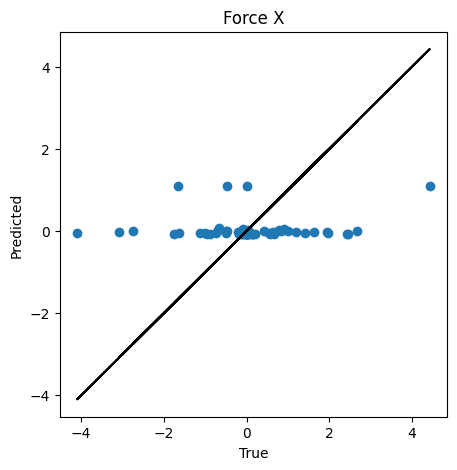

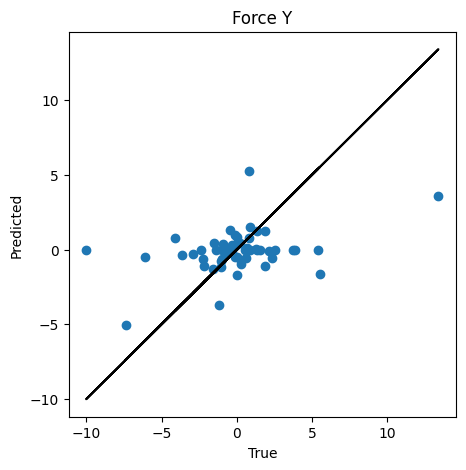

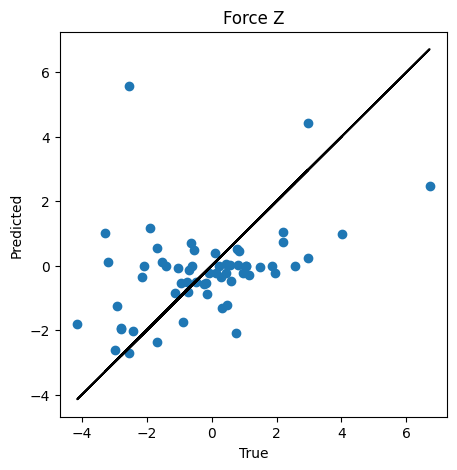

In [38]:

plt.figure(figsize=(5, 5))
plt.plot(y_force_val_x, y_force_pred_x, 'o')
plt.plot(y_force_val_x, y_force_val_x, 'k-')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Force X')

plt.figure(figsize=(5, 5))
plt.plot(y_force_val_y, y_force_pred_y, 'o')
plt.plot(y_force_val_y, y_force_val_y, 'k-')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Force Y')

plt.figure(figsize=(5, 5))
plt.plot(y_force_val_z, y_force_pred_z, 'o')
plt.plot(y_force_val_z, y_force_val_z, 'k-')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Force Z')





/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

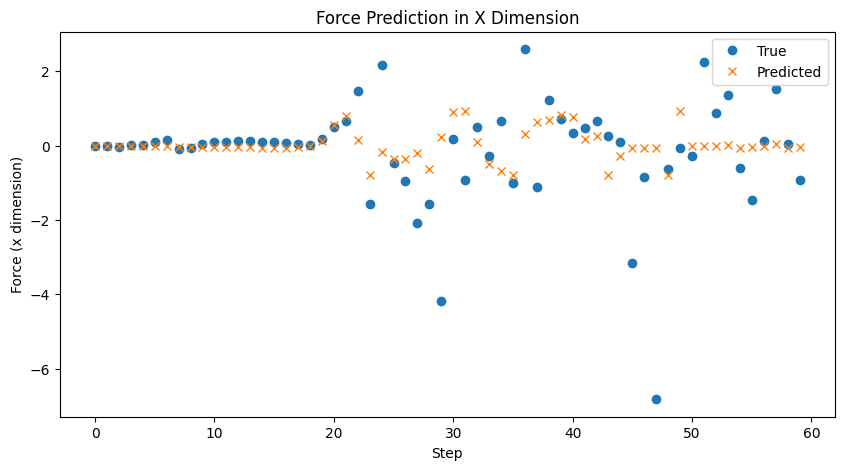

/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

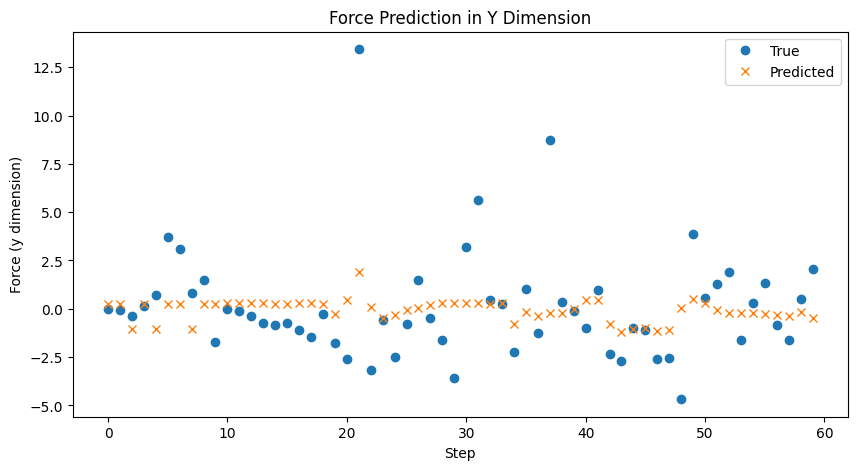

/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grantwilkins/anaconda3/envs/fedsz/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnin

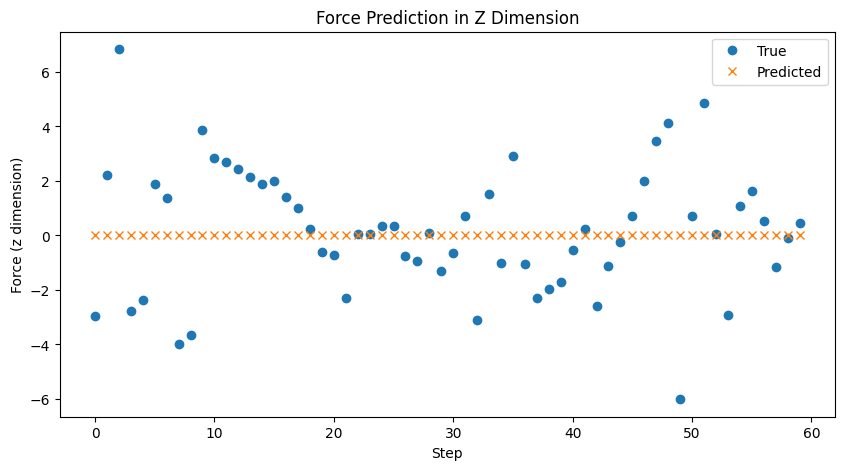

In [47]:
def train_and_predict(X_train, y_train, X_validate, y_validate):
    def objective_function(params):
        constant_value, rbf_length_scale, noise_level = params

        # Define the kernel with the current hyperparameters
        kernel = ConstantKernel(constant_value, (1e-3, 1e6)) * RBF(rbf_length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level=noise_level)
        
        # Initialize and train the Gaussian Process model
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(X_train, y_train)

        # Predict on a validation set and calculate MSE
        y_pred = gp.predict(X_validate)
        mse = mean_squared_error(y_validate, y_pred)
        return mse

    # Hyperparameter optimization
    space = [
        Real(1e-3, 1e6, name='constant_value'),
        Real(1e-2, 1e2, name='rbf_length_scale'),
        Real(1e-10, 1, name='noise_level')
    ]
    
    result = gp_minimize(
        objective_function,
        space,
        acq_func="EI",
        n_calls=50,
        n_random_starts=10,
        random_state=123
    )

    # Best kernel from optimization
    kernel = ConstantKernel(result.x[0], (1e-3, 1e6)) * RBF(result.x[1], (1e-2, 1e2)) + WhiteKernel(noise_level=result.x[2])
    
    # Train the Gaussian Process Regressor with the optimized kernel
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, y_train)

    # Predict and return the predictions
    return gp.predict(X_validate)

# Dimension names for plotting
dimensions = ['x', 'y', 'z']

# Loop through each dimension and perform training and prediction
for i, dim in enumerate(dimensions):
    X_train_dim = X_train[:, i].reshape(len(X_train), -1)
    y_train_dim = y_force_train[:, i].reshape(len(y_force_train), -1)
    X_validate_dim = X_validate[:, i].reshape(len(X_validate), -1)
    y_validate_dim = y_force_val[:, i].reshape(len(y_force_val), -1)

    # Train and predict for the current dimension
    y_pred_dim = train_and_predict(X_train_dim, y_train_dim, X_validate_dim, y_validate_dim)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_validate_dim)), y_validate_dim, 'o')
    plt.plot(range(len(y_pred_dim)), y_pred_dim, 'x')
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Step')
    plt.ylabel(f'Force ({dim} dimension)')
    plt.title(f'Force Prediction in {dim.upper()} Dimension')
    plt.show()